# 1) Dataset Definition

In this dataset, we have some disaster tweets but some tweets are real disasters some are not. In this project, we want to detect real disaster tweets according to this dataset.

# 2) Import Libraries

We will import necessary libraries for this project.

In [3]:
import pandas as pd
import numpy as np
import nltk
import spacy
import unicodedata
import re
from nltk.corpus import wordnet
import collections
#from textblob import Word
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import os
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, \
                            f1_score, confusion_matrix
from nltk.tokenize.toktok import ToktokTokenizer
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, XLNetTokenizer, XLNetForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/Users/mert.alacan/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# 3) Text Preprocessing

We are doing our projects with tweets. So, we have some strange expressions like html tags, url, emoji etc. Additionally, we should clean unnecessary expressions like hashtags, stopwords, punctuations, digits etc and we can expand some contraction expressions.

In [4]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [5]:
def remove_url(text):
    url_text = re.compile(r'https?://\S+|www\.\S+')
    return url_text.sub(r'', text)

def remove_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emojis.sub(r'', text)

def remove_html(text):
    html_tags = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html_tags, '', text)

def remove_other_unnecessary_expression(text):

    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def get_lemmatized_text(text):
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in word_tokenize(text))
    return text

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


def remove_stopwords(text):
    stop_words = stopwords.words('english')
    stop_words.remove('no')
    stop_words.remove('but')
    stop_words.remove('not')
    #more_stopwords = ['u', 'im', 'c']
    #stop_words = stop_words + more_stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

def general_text_preprocessing(text):

    global CONTRACTION_MAP
    text = re.sub(' +', ' ', text)
    text = text.lower()
    contractions = CONTRACTION_MAP

    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    text = remove_other_unnecessary_expression(text)
    text = expand_contractions(text, contraction_mapping=contractions)
    text = remove_stopwords(text)
    text = get_lemmatized_text(text)

    text = re.sub(' +', ' ', text)
    text = text.strip()

    return text

def general_text_preprocessing_except_stopwords_and_lemmatization(text):

    global CONTRACTION_MAP
    text = re.sub(' +', ' ', text)
    text = text.lower()
    contractions = CONTRACTION_MAP

    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    text = remove_other_unnecessary_expression(text)
    text = expand_contractions(text, contraction_mapping=contractions)


    text = re.sub(' +', ' ', text)
    text = text.strip()

    return text

def remove_url_emoji_html_tags(text):

    global CONTRACTION_MAP
    text = re.sub(' +', ' ', text)
    text = text.lower()
    contractions = CONTRACTION_MAP

    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)


    text = re.sub(' +', ' ', text)
    text = text.strip()

    return text


In [6]:
df = pd.read_csv("disaster_tweet_dataset.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
df["cleaned_text_1"] = df["text"].apply(general_text_preprocessing)
df["cleaned_text_2"] = df["text"].apply(general_text_preprocessing_except_stopwords_and_lemmatization)
df["cleaned_text_3"] = df["text"].apply(remove_url_emoji_html_tags)

We did some data preprocessing. These are remove html, url, stopwords, punctuations, unnecessary other expressions. Additionally, we expanded contractions and lemmatized words. We applied these processes into cleaned_text_1, cleaned_text_2 and cleaned_text_3. If we enter the details:

* Cleaned_text_1: This column includes whole data processing
* Cleaned_text_2: This column includes whole data processing except removing stopwords and lemmatizing. 
* Cleaned_text_3: This column includes removing url, html and emoji.

In [ ]:
df

,id,keyword,location,text,target,cleaned_text_1,cleaned_text_2,cleaned_text_3
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u,our deeds are the reason of this earthquake ma...,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...,all residents asked to shelter in place are be...,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...,people receive wildfires evacuation orders in ...,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...,just got sent this photo from ruby alaska as s...,just got sent this photo from ruby #alaska as ...
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant crane holding bridge collapse nearby...,two giant cranes holding a bridge collapse int...,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary thetawniest control wild fire calif...,ariaahrary thetawniest the out of control wild...,@aria_ahrary @thetawniest the out of control w...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,volcano hawaii,s of volcano hawaii,m1.94 [01:04 utc]?5km s of volcano hawaii.
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating ebike collided car little...,police investigating after an ebike collided w...,police investigating after an e-bike collided ...


# 4) Data Visualization

We would like to recognize our dataset with some visuals, so we will form some visuals

/Users/mert.alacan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mert.alacan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mert.alacan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


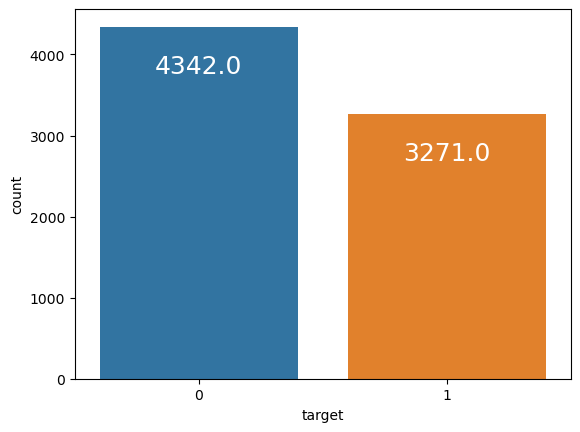

In [ ]:
ax=sns.countplot(x='target', data=df);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+p.get_width()/2., p.get_height() + 1), ha='center', va='top', color='white', size=18)

In this countplot, we see that in our total dataset, we have 3271 real disaster tweets and 4342 fake disaster tweets

In [ ]:
def create_corpus_df(tweet, target, column_name):
    corpus=[]

    for x in tweet[tweet['target']==target][column_name].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
corpus_disaster_tweets = create_corpus_df(df, 1, "cleaned_text_1")

dic=defaultdict(int)
for word in corpus_disaster_tweets:
    dic[word]+=1

top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('fire', 261),
 ('news', 132),
 ('via', 121),
 ('disaster', 117),
 ('california', 115),
 ('suicide', 110),
 ('no', 106),
 ('people', 106),
 ('police', 106),
 ('family', 105)]

In real disaster tweets, top 10 words are seen above. These are fire, news, via, disaster etc.

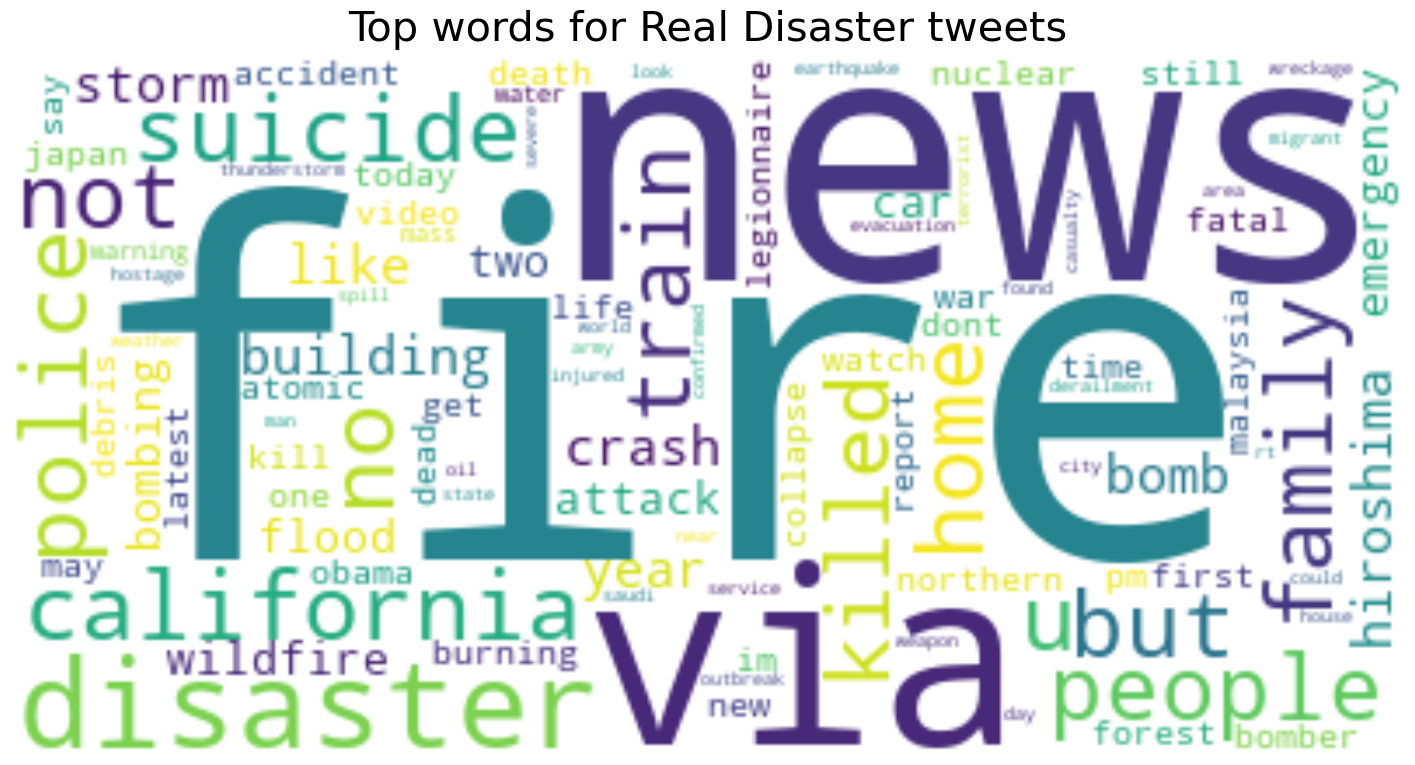

In [ ]:
plt.figure(figsize=(18,10))
wordcloud = WordCloud(background_color='white',max_words=100).generate_from_frequencies(dic)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top words for Real Disaster tweets',
          fontdict={'size': 30,  'verticalalignment': 'bottom'})
plt.axis("off")
plt.show()

In [ ]:
corpus_disaster_tweets = create_corpus_df(df, 0, "cleaned_text_1")

dic=defaultdict(int)
for word in corpus_disaster_tweets:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('like', 254),
 ('im', 240),
 ('but', 213),
 ('not', 207),
 ('get', 184),
 ('new', 168),
 ('no', 145),
 ('u', 139),
 ('dont', 139),
 ('one', 134)]

In fake disaster tweets, top 10 words are seen above.

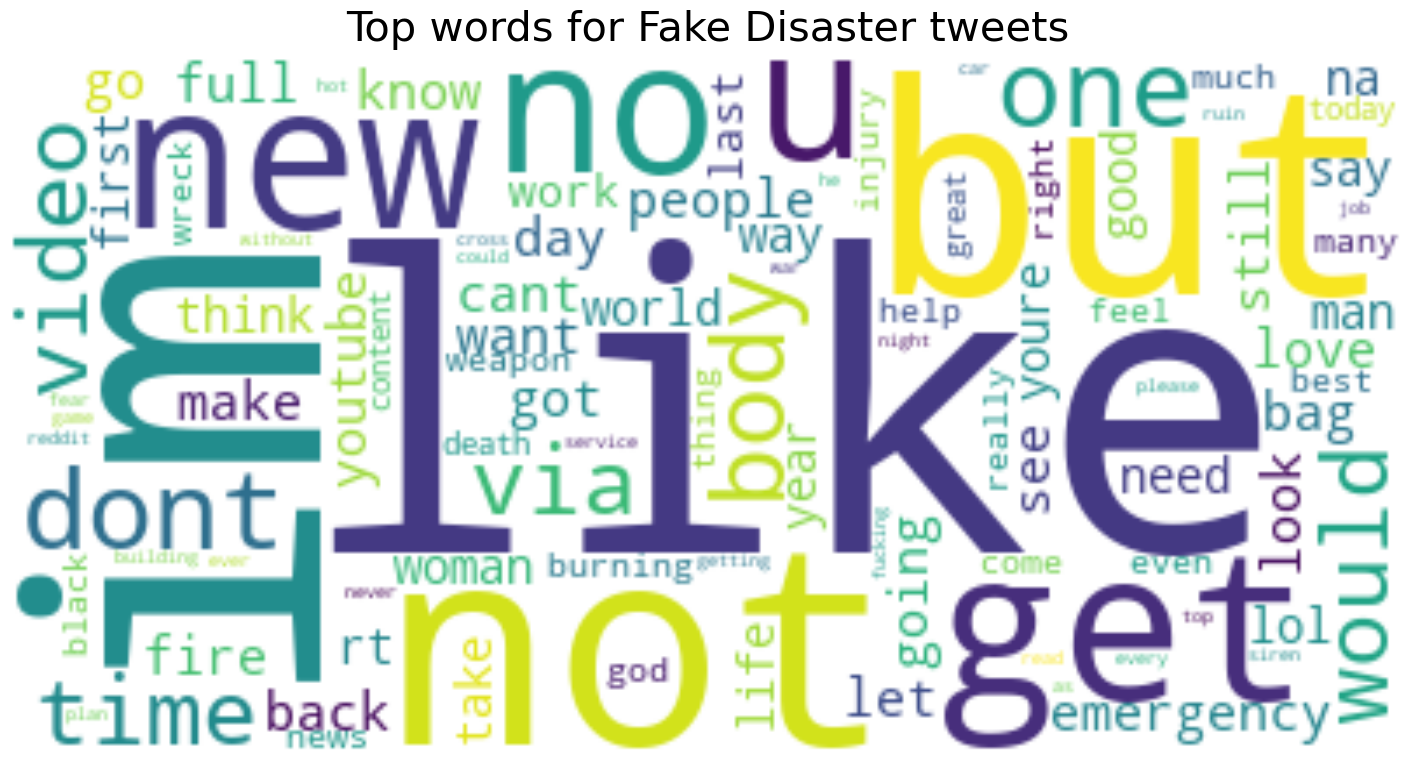

In [ ]:
plt.figure(figsize=(18,10))
wordcloud = WordCloud(background_color='white',max_words=100).generate_from_frequencies(dic)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top words for Fake Disaster tweets',
          fontdict={'size': 30,  'verticalalignment': 'bottom'})
plt.axis("off")
plt.show()

# 5) Traditional Machine Learning Modelling

We will model our dataset according to cleaned texts and raw text. We will apply some vectorization processes and then put into traditional machine learning models.

Vectorizations:
* Count Vectorizer (Bag of Words)
* TF-IDF (Term Frequencies - Inverse Document Frequency) (with ngrams:1-1 and 1-2)
* Word2Vec
* Fasttext

ML Models:
* Naive Bayes
* Logistic Regression
* Random Forest
* Xgboost


Every vector & model combinations will be applied.

In [21]:
nb_clf = GaussianNB()
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
xgb_clf = xgb.XGBClassifier()

In [22]:
model_list = [('Naive Bayes', nb_clf),
             ('Logistic Regression',lr_clf),
             ('Random Forest',rf_clf),
             ('Xgboost',xgb_clf)]

In [23]:
def train_classification_model(classifier, X_train, y_train, X_test):

    #Fit ML model function
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    return predictions

def get_metrics(y_test, y_pred, model_name, classes):

    #Show metric results
    print("Model Name:",model_name)

    print("\nMetric Results")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test,y_pred))
    print('Recall:', recall_score(y_test,y_pred))
    print('F1 Score:', f1_score(y_test,y_pred))

    print("\n------------------------------")

    print("\nClassification Report:")
    report = classification_report(y_test, y_pred)
    print(report)


## 5.1) CountVectorizer Results

Firstly, we use BoW model with ML models over cleaned_text_1 feature.

In [ ]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,1))

# Fit and transform the training data
df_counts = vectorizer.fit_transform(df['cleaned_text_1'])

# Convert sparse matrix to dense numpy array
df_counts_dense = df_counts.toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_counts_dense, df.target, test_size=0.2, random_state=42)

In [ ]:
print('BOW model:> Train features shape:', X_train.shape,
      ' Test features shape:', X_test.shape)

BOW model:> Train features shape: (6090, 15191)  Test features shape: (1523, 15191)


In [ ]:
for model in model_list:
    y_pred = train_classification_model(model[1], X_train, y_train, X_test)
    get_metrics(y_test, y_pred, model[0], classes=['positive', 'negative'])

Model Name: Naive Bayes

Metric Results
Accuracy: 0.6158896913985554
Precision: 0.5323886639676113
Recall: 0.810477657935285
F1 Score: 0.6426389737324374

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.47      0.58       874
           1       0.53      0.81      0.64       649

    accuracy                           0.62      1523
   macro avg       0.65      0.64      0.61      1523
weighted avg       0.67      0.62      0.61      1523

Model Name: Logistic Regression

Metric Results
Accuracy: 0.7918581746552856
Precision: 0.7832764505119454
Recall: 0.7072419106317411
F1 Score: 0.7433198380566801

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       874
           1       0.78      0.71      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79   

We see that best results came from Logistic Regression

## 5.2) TF-IDF Results

Secondly, we use TF-IDF model with ML models over cleaned_text_1 feature.

### 5.2.1) TF-IDF 1-1 ngram Results

In [ ]:
# Initialize TFIDFVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,1))

# Fit and transform the training data
df_counts = vectorizer.fit_transform(df['cleaned_text_1'])

# Convert sparse matrix to dense numpy array
df_counts_dense = df_counts.toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_counts_dense, df.target, test_size=0.2, random_state=42)

In [ ]:
print('TF-IDF 1-1 model:> Train features shape:', X_train.shape,
      ' Test features shape:', X_test.shape)

TF-IDF 1-1 model:> Train features shape: (6090, 15191)  Test features shape: (1523, 15191)


In [ ]:
for model in model_list:
    y_pred = train_classification_model(model[1], X_train, y_train, X_test)
    get_metrics(y_test, y_pred, model[0], classes=['positive', 'negative'])

Model Name: Naive Bayes

Metric Results
Accuracy: 0.6086671043992121
Precision: 0.5276329509906152
Recall: 0.7796610169491526
F1 Score: 0.6293532338308457

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.48      0.59       874
           1       0.53      0.78      0.63       649

    accuracy                           0.61      1523
   macro avg       0.64      0.63      0.61      1523
weighted avg       0.65      0.61      0.60      1523

Model Name: Logistic Regression

Metric Results
Accuracy: 0.7957977675640184
Precision: 0.8421052631578947
Recall: 0.6409861325115562
F1 Score: 0.7279090113735783

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       874
           1       0.84      0.64      0.73       649

    accuracy                           0.80      1523
   macro avg       0.81  

Best results came from Logistic Regression for TF-IDF 1-1 ngram.

### 5.2.2) TF-IDF 1-2 ngram Results

In [ ]:
# Initialize TFIDFVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))

# Fit and transform the training data
df_counts = vectorizer.fit_transform(df['cleaned_text_1'])

# Convert sparse matrix to dense numpy array
df_counts_dense = df_counts.toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_counts_dense, df.target, test_size=0.2, random_state=42)

In [ ]:
print('TF-IDF 1-2 model:> Train features shape:', X_train.shape,
      ' Test features shape:', X_test.shape)

TF-IDF 1-2 model:> Train features shape: (6090, 60792)  Test features shape: (1523, 60792)


In [ ]:
for model in model_list:
    y_pred = train_classification_model(model[1], X_train, y_train, X_test)
    get_metrics(y_test, y_pred, model[0], classes=['positive', 'negative'])

Model Name: Naive Bayes

Metric Results
Accuracy: 0.6513460275771503
Precision: 0.5686046511627907
Recall: 0.7534668721109399
F1 Score: 0.6481113320079522

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.58      0.65       874
           1       0.57      0.75      0.65       649

    accuracy                           0.65      1523
   macro avg       0.66      0.66      0.65      1523
weighted avg       0.68      0.65      0.65      1523

Model Name: Logistic Regression

Metric Results
Accuracy: 0.7820091923834537
Precision: 0.8819277108433735
Recall: 0.5639445300462249
F1 Score: 0.68796992481203

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       874
           1       0.88      0.56      0.69       649

    accuracy                           0.78      1523
   macro avg       0.81    

Best results came from Logistic Regression for TF-IDF 1-2 ngram but when we compared with 1-1 ngram TF-IDF, 1-1 ngram was better than 1-2 ngram.

## 5.3) Word2Vec Results

Word2Vec embedding looks the mean of text so we did not look just cleaned_text_1. Because of contextual capability, we looked with cleaned_text_2, cleaned_text_3 and raw text features.

### 5.3.1) Cleaned_text_1 Results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df['cleaned_text_1']),  np.array(df['target']),
                                                    test_size=0.2, random_state=42)

In [ ]:
tokenizer = ToktokTokenizer()
X_train_tokens = [tokenizer.tokenize(text) for text in X_train]
X_test_tokens = [tokenizer.tokenize(text) for text in X_test]

In [ ]:
import gensim
# Build word2vec model with 1024 vector size, 50 epochs, 100 windows and CBoW approach
w2v_num_features = 1024
w2v_model = gensim.models.Word2Vec(X_train_tokens, vector_size=w2v_num_features, window=100,
                                   min_count=2, sample=1e-3, sg=1, epochs=50, workers=10)

In [16]:
def document_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)

    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.

        for word in words:
            if word in vocabulary:
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
# Generate averaged word vector features from word2vec model
X_train_avg_features = document_vectorizer(corpus=X_train_tokens, model=w2v_model,
                                                     num_features=w2v_num_features)
X_test_avg_features = document_vectorizer(corpus=X_test_tokens, model=w2v_model,
                                                    num_features=w2v_num_features)

In [ ]:
print('Word2Vec model:> Train features shape:', X_train_avg_features.shape,
      ' Test features shape:', X_test_avg_features.shape)

Word2Vec model:> Train features shape: (6090, 1024)  Test features shape: (1523, 1024)


In [ ]:
for model in model_list:
    y_pred = train_classification_model(model[1], X_train_avg_features, y_train, X_test_avg_features)
    get_metrics(y_test, y_pred, model[0], classes=['positive', 'negative'])

Model Name: Naive Bayes

Metric Results
Accuracy: 0.7655942219304005
Precision: 0.7339743589743589
Recall: 0.7057010785824345
F1 Score: 0.7195600942655145

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       874
           1       0.73      0.71      0.72       649

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.76      0.77      0.76      1523



/Users/mert.alacan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Name: Logistic Regression

Metric Results
Accuracy: 0.7774130006565988
Precision: 0.7700348432055749
Recall: 0.6810477657935285
F1 Score: 0.722812755519215

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       874
           1       0.77      0.68      0.72       649

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523

Model Name: Random Forest

Metric Results
Accuracy: 0.7898883782009193
Precision: 0.8296593186372746
Recall: 0.637904468412943
F1 Score: 0.7212543554006969

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       874
           1       0.83      0.64      0.72       649

    accuracy                           0.79      1523
   macro avg       0.80  

Random Forest and XGBoost models gave best results.

### 5.3.2) Cleaned_text_2 Results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df['cleaned_text_2']),
                                                    np.array(df['target']),
                                                    test_size=0.2, random_state=42)

tokenizer = ToktokTokenizer()
X_train_tokens = [tokenizer.tokenize(text) for text in X_train]
X_test_tokens = [tokenizer.tokenize(text) for text in X_test]

import gensim
# build word2vec model
w2v_num_features = 1024
w2v_model = gensim.models.Word2Vec(X_train_tokens, vector_size=w2v_num_features, window=100,
                                   min_count=2, sample=1e-3, sg=1, epochs=50, workers=10)

X_train_avg_features = document_vectorizer(corpus=X_train_tokens, model=w2v_model,
                                                     num_features=w2v_num_features)
X_test_avg_features = document_vectorizer(corpus=X_test_tokens, model=w2v_model,
                                                    num_features=w2v_num_features)

print('Word2Vec model:> Train features shape:', X_train_avg_features.shape,
      ' Test features shape:', X_test_avg_features.shape)

Word2Vec model:> Train features shape: (6090, 1024)  Test features shape: (1523, 1024)


In [ ]:
for model in model_list:
    y_pred = train_classification_model(model[1], X_train_avg_features, y_train, X_test_avg_features)
    get_metrics(y_test, y_pred, model[0], classes=['positive', 'negative'])

Model Name: Naive Bayes

Metric Results
Accuracy: 0.7380170715692712
Precision: 0.7470355731225297
Recall: 0.5824345146379045
F1 Score: 0.6545454545454545

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       874
           1       0.75      0.58      0.65       649

    accuracy                           0.74      1523
   macro avg       0.74      0.72      0.72      1523
weighted avg       0.74      0.74      0.73      1523

Model Name: Logistic Regression

Metric Results
Accuracy: 0.7925147734734077
Precision: 0.7926186291739895
Recall: 0.6949152542372882
F1 Score: 0.7405582922824303

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.83       874
           1       0.79      0.69      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79  

Logistic Regression gave best results. We have better results than cleaned_text_1.

### 5.3.3) Cleaned_text_3 Results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df['cleaned_text_3']),
                                                    np.array(df['target']),
                                                    test_size=0.2, random_state=42)

tokenizer = ToktokTokenizer()
X_train_tokens = [tokenizer.tokenize(text) for text in X_train]
X_test_tokens = [tokenizer.tokenize(text) for text in X_test]

import gensim
# build word2vec model
w2v_num_features = 1024
w2v_model = gensim.models.Word2Vec(X_train_tokens, vector_size=w2v_num_features, window=100,
                                   min_count=2, sample=1e-3, sg=1, epochs=50, workers=10)

X_train_avg_features = document_vectorizer(corpus=X_train_tokens, model=w2v_model,
                                                     num_features=w2v_num_features)
X_test_avg_features = document_vectorizer(corpus=X_test_tokens, model=w2v_model,
                                                    num_features=w2v_num_features)

print('Word2Vec model:> Train features shape:', X_train_avg_features.shape,
      ' Test features shape:', X_test_avg_features.shape)

Word2Vec model:> Train features shape: (6090, 1024)  Test features shape: (1523, 1024)


In [ ]:
for model in model_list:
    y_pred = train_classification_model(model[1], X_train_avg_features, y_train, X_test_avg_features)
    get_metrics(y_test, y_pred, model[0], classes=['positive', 'negative'])

Model Name: Naive Bayes

Metric Results
Accuracy: 0.7321076822061721
Precision: 0.7405189620758483
Recall: 0.5716486902927581
F1 Score: 0.6452173913043479

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       874
           1       0.74      0.57      0.65       649

    accuracy                           0.73      1523
   macro avg       0.73      0.71      0.72      1523
weighted avg       0.73      0.73      0.73      1523



/Users/mert.alacan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Name: Logistic Regression

Metric Results
Accuracy: 0.7826657912015759
Precision: 0.7819148936170213
Recall: 0.6795069337442219
F1 Score: 0.7271228359439407

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       874
           1       0.78      0.68      0.73       649

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523

Model Name: Random Forest

Metric Results
Accuracy: 0.7767564018384767
Precision: 0.8395604395604396
Recall: 0.588597842835131
F1 Score: 0.6920289855072463

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.82       874
           1       0.84      0.59      0.69       649

    accuracy                           0.78      1523
   macro avg       0.79 

Tree based XGBoost model gave best results. It has better than cleaned_text_2.

### 5.3.4) Raw Text Results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df['text']),
                                                    np.array(df['target']),
                                                    test_size=0.2, random_state=42)

tokenizer = ToktokTokenizer()
X_train_tokens = [tokenizer.tokenize(text) for text in X_train]
X_test_tokens = [tokenizer.tokenize(text) for text in X_test]

import gensim
# build word2vec model
w2v_num_features = 1024
w2v_model = gensim.models.Word2Vec(X_train_tokens, vector_size=w2v_num_features, window=100,
                                   min_count=2, sample=1e-3, sg=1, epochs=50, workers=10)

X_train_avg_features = document_vectorizer(corpus=X_train_tokens, model=w2v_model,
                                                     num_features=w2v_num_features)
X_test_avg_features = document_vectorizer(corpus=X_test_tokens, model=w2v_model,
                                                    num_features=w2v_num_features)

print('Word2Vec model:> Train features shape:', X_train_avg_features.shape,
      ' Test features shape:', X_test_avg_features.shape)

Word2Vec model:> Train features shape: (6090, 1024)  Test features shape: (1523, 1024)


In [ ]:
for model in model_list:
    y_pred = train_classification_model(model[1], X_train_avg_features, y_train, X_test_avg_features)
    get_metrics(y_test, y_pred, model[0], classes=['positive', 'negative'])

Model Name: Naive Bayes

Metric Results
Accuracy: 0.6979645436638214
Precision: 0.6793168880455408
Recall: 0.551617873651772
F1 Score: 0.608843537414966

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.81      0.75       874
           1       0.68      0.55      0.61       649

    accuracy                           0.70      1523
   macro avg       0.69      0.68      0.68      1523
weighted avg       0.70      0.70      0.69      1523

Model Name: Logistic Regression

Metric Results
Accuracy: 0.7701904136572554
Precision: 0.7693693693693694
Recall: 0.6579352850539292
F1 Score: 0.7093023255813954

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       874
           1       0.77      0.66      0.71       649

    accuracy                           0.77      1523
   macro avg       0.77    

Logistic Regression gave the best results but it did not pass cleaned_text_3.

### 5.3.5) Word2Vec General Result

We looked 4 different feature based model results. Cleaned_text_3 gave the best results with XGBoost model. We saw .8 accuracy and .75 f1-score.

## 5.4) Fasttext Results

Fasttext embedding looks the mean of text so we did not look just cleaned_text_1. Because of contextual capability, we looked with cleaned_text_2, cleaned_text_3 and raw text features.

### 5.4.1) Cleaned_text_1 Results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df['cleaned_text_1']),  np.array(df['target']),
                                                    test_size=0.2, random_state=42)

In [ ]:
from gensim.models.fasttext import FastText

ft_num_features = 1024

ft_model = FastText(X_train_tokens, vector_size=ft_num_features, window=100,
                    min_count=2, sample=1e-3, sg=1, epochs=80, workers=10)

In [ ]:
X_train_avg_features = document_vectorizer(corpus=X_train_tokens, model=ft_model,
                                                     num_features=ft_num_features)
X_test_avg_features = document_vectorizer(corpus=X_test_tokens, model=ft_model,
                                                    num_features=ft_num_features)

In [ ]:
print('FastText model:> Train features shape:', X_train_avg_features.shape,
      ' Test features shape:', X_test_avg_features.shape)

FastText model:> Train features shape: (6090, 1024)  Test features shape: (1523, 1024)


In [ ]:
for model in model_list:
    y_pred = train_classification_model(model[1], X_train_avg_features, y_train, X_test_avg_features)
    get_metrics(y_test, y_pred, model[0], classes=['positive', 'negative'])

Model Name: Naive Bayes

Metric Results
Accuracy: 0.6776099803020355
Precision: 0.6618852459016393
Recall: 0.49768875192604006
F1 Score: 0.5681618293755497

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.81      0.74       874
           1       0.66      0.50      0.57       649

    accuracy                           0.68      1523
   macro avg       0.67      0.65      0.66      1523
weighted avg       0.68      0.68      0.67      1523



/Users/mert.alacan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Name: Logistic Regression

Metric Results
Accuracy: 0.7741300065659882
Precision: 0.7808471454880295
Recall: 0.6533127889060092
F1 Score: 0.7114093959731542

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       874
           1       0.78      0.65      0.71       649

    accuracy                           0.77      1523
   macro avg       0.78      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523

Model Name: Random Forest

Metric Results
Accuracy: 0.7623112278397899
Precision: 0.8126361655773421
Recall: 0.5747303543913713
F1 Score: 0.6732851985559566

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       874
           1       0.81      0.57      0.67       649

    accuracy                           0.76      1523
   macro avg       0.78

Best results came from XGBoost model.

### 5.4.2) Cleaned_text_2 Results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df['cleaned_text_2']),
                                                    np.array(df['target']),
                                                    test_size=0.2, random_state=42)

In [ ]:
tokenizer = ToktokTokenizer()
X_train_tokens = [tokenizer.tokenize(text) for text in X_train]
X_test_tokens = [tokenizer.tokenize(text) for text in X_test]

In [ ]:
from gensim.models.fasttext import FastText

ft_num_features = 1024

ft_model = FastText(X_train_tokens, vector_size=ft_num_features, window=100,
                    min_count=2, sample=1e-3, sg=1, epochs=80, workers=10)

In [ ]:
X_train_avg_features = document_vectorizer(corpus=X_train_tokens, model=ft_model,
                                                     num_features=ft_num_features)
X_test_avg_features = document_vectorizer(corpus=X_test_tokens, model=ft_model,
                                                    num_features=ft_num_features)

In [ ]:
print('FastText model:> Train features shape:', X_train_avg_features.shape,
      ' Test features shape:', X_test_avg_features.shape)

FastText model:> Train features shape: (6090, 1024)  Test features shape: (1523, 1024)


In [ ]:
for model in model_list:
    y_pred = train_classification_model(model[1], X_train_avg_features, y_train, X_test_avg_features)
    get_metrics(y_test, y_pred, model[0], classes=['positive', 'negative'])

Model Name: Naive Bayes

Metric Results
Accuracy: 0.7294812869336835
Precision: 0.7248576850094877
Recall: 0.588597842835131
F1 Score: 0.6496598639455783

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       874
           1       0.72      0.59      0.65       649

    accuracy                           0.73      1523
   macro avg       0.73      0.71      0.71      1523
weighted avg       0.73      0.73      0.72      1523



/Users/mert.alacan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Name: Logistic Regression

Metric Results
Accuracy: 0.7898883782009193
Precision: 0.7932263814616756
Recall: 0.6856702619414484
F1 Score: 0.7355371900826446

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       874
           1       0.79      0.69      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

Model Name: Random Forest

Metric Results
Accuracy: 0.7741300065659882
Precision: 0.817047817047817
Recall: 0.6055469953775039
F1 Score: 0.695575221238938

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       874
           1       0.82      0.61      0.70       649

    accuracy                           0.77      1523
   macro avg       0.79  

Best results came from XGBoost. Cleaned_text_2 results were better than cleaned_text_1

### 5.4.3) Cleaned_text_3 Results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df['cleaned_text_3']),
                                                    np.array(df['target']),
                                                    test_size=0.2, random_state=42)

In [ ]:
tokenizer = ToktokTokenizer()
X_train_tokens = [tokenizer.tokenize(text) for text in X_train]
X_test_tokens = [tokenizer.tokenize(text) for text in X_test]

In [ ]:
from gensim.models.fasttext import FastText

ft_num_features = 1024

ft_model = FastText(X_train_tokens, vector_size=ft_num_features, window=100,
                    min_count=2, sample=1e-3, sg=1, epochs=80, workers=10)

In [ ]:
X_train_avg_features = document_vectorizer(corpus=X_train_tokens, model=ft_model,
                                                     num_features=ft_num_features)
X_test_avg_features = document_vectorizer(corpus=X_test_tokens, model=ft_model,
                                                    num_features=ft_num_features)

In [ ]:
print('FastText model:> Train features shape:', X_train_avg_features.shape,
      ' Test features shape:', X_test_avg_features.shape)

FastText model:> Train features shape: (6090, 1024)  Test features shape: (1523, 1024)


In [ ]:
for model in model_list:
    y_pred = train_classification_model(model[1], X_train_avg_features, y_train, X_test_avg_features)
    get_metrics(y_test, y_pred, model[0], classes=['positive', 'negative'])

Model Name: Naive Bayes

Metric Results
Accuracy: 0.7058437294812869
Precision: 0.7089397089397089
Recall: 0.5254237288135594
F1 Score: 0.6035398230088496

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.84      0.77       874
           1       0.71      0.53      0.60       649

    accuracy                           0.71      1523
   macro avg       0.71      0.68      0.68      1523
weighted avg       0.71      0.71      0.70      1523

Model Name: Logistic Regression

Metric Results
Accuracy: 0.7866053841103086
Precision: 0.7882562277580071
Recall: 0.6825885978428351
F1 Score: 0.7316267547481421

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       874
           1       0.79      0.68      0.73       649

    accuracy                           0.79      1523
   macro avg       0.79  

Best results came from XGBoost but cleaned_text_2 was better than cleaned_text_3.

### 5.4.4) Raw Text Results

In [9]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df['text']),
                                                    np.array(df['target']),
                                                    test_size=0.2, random_state=42)

In [10]:
tokenizer = ToktokTokenizer()
X_train_tokens = [tokenizer.tokenize(text) for text in X_train]
X_test_tokens = [tokenizer.tokenize(text) for text in X_test]

In [13]:
from gensim.models.fasttext import FastText

ft_num_features = 1024

ft_model = FastText(X_train_tokens, vector_size=ft_num_features, window=100,
                    min_count=2, sample=1e-3, sg=1, epochs=80, workers=10)

In [17]:
X_train_avg_features = document_vectorizer(corpus=X_train_tokens, model=ft_model,
                                                     num_features=ft_num_features)
X_test_avg_features = document_vectorizer(corpus=X_test_tokens, model=ft_model,
                                                    num_features=ft_num_features)

In [18]:
print('FastText model:> Train features shape:', X_train_avg_features.shape,
      ' Test features shape:', X_test_avg_features.shape)

FastText model:> Train features shape: (6090, 1024)  Test features shape: (1523, 1024)


In [24]:
for model in model_list:
    y_pred = train_classification_model(model[1], X_train_avg_features, y_train, X_test_avg_features)
    get_metrics(y_test, y_pred, model[0], classes=['positive', 'negative'])

Model Name: Naive Bayes

Metric Results
Accuracy: 0.6815495732107683
Precision: 0.6701244813278008
Recall: 0.49768875192604006
F1 Score: 0.5711759504862952

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       874
           1       0.67      0.50      0.57       649

    accuracy                           0.68      1523
   macro avg       0.68      0.66      0.66      1523
weighted avg       0.68      0.68      0.67      1523



/Users/mert.alacan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Name: Logistic Regression

Metric Results
Accuracy: 0.7754432042022325
Precision: 0.7806215722120659
Recall: 0.6579352850539292
F1 Score: 0.714046822742475

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.82       874
           1       0.78      0.66      0.71       649

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.76      1523
weighted avg       0.78      0.78      0.77      1523

Model Name: Random Forest

Metric Results
Accuracy: 0.7616546290216678
Precision: 0.8163716814159292
Recall: 0.5685670261941448
F1 Score: 0.6702997275204359

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.81       874
           1       0.82      0.57      0.67       649

    accuracy                           0.76      1523
   macro avg       0.78 

Best results came from XGBoost but cleaned_text_2 was better than raw text.

### 5.4.5) FastText General Results 

We looked 4 different feature based model results. Cleaned_text_2 gave the best results with XGBoost model. We saw .8 accuracy and .76 f1-score. We also say that FastText best results passed the best Word2Vec results.

# 6) Pre-Trained Based Models

We tried to get result with pre-trained models such as BERT and XLNet. In traditional machine learning based approaches with several embedding methods, we actually got good results but we want to get better results with pre-trained models.

## 6.1) BERT Model

BERT pre-trained model looks the mean of text so we did not look just cleaned_text_1. Because of contextual capability, we looked with cleaned_text_2, cleaned_text_3 and raw text features.

### 6.1.1) Raw Text Results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(),
                                                    df['target'].tolist(),
                                                    test_size=0.2, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test))

In [ ]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SequentialSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels': batch[2].to(device)}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)

    # Evaluation on test data
    model.eval()
    preds = []
    true_labels = []
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device)}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, axis=1).tolist())
        true_labels.extend(batch[2].to(device).tolist())

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, preds)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Train Loss: {avg_train_loss}, Accuracy: {accuracy}')
    print("Accuracy:", accuracy_score(true_labels, preds))
    print('Precision:', precision_score(true_labels, preds))
    print('Recall:', recall_score(true_labels, preds))
    print('F1 Score:', f1_score(true_labels, preds))

    print("\n------------------------------")

    print("\nClassification Report:")
    report = classification_report(true_labels, preds)
    print(report)

Epoch 1/4, Avg Train Loss: 0.43725071649062514, Accuracy: 0.8371634931057124
Accuracy: 0.8371634931057124
Precision: 0.814756671899529
Recall: 0.7996918335901386
F1 Score: 0.8071539657853809

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       874
           1       0.81      0.80      0.81       649

    accuracy                           0.84      1523
   macro avg       0.83      0.83      0.83      1523
weighted avg       0.84      0.84      0.84      1523

Epoch 2/4, Avg Train Loss: 0.2993610252320387, Accuracy: 0.8240315167432699
Accuracy: 0.8240315167432699
Precision: 0.7822222222222223
Recall: 0.8135593220338984
F1 Score: 0.7975830815709969

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       874
           1       0.78      0.81      0.80       649

    accuracy   

In just first epoch, we get the best results. .8071 f1-score and .8371 accuracy scores were brilliant. It was better than FastText and Word2Vec results.

### 6.1.2) Cleaned_Text_3 Results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text_3'].tolist(),
                                                    df['target'].tolist(),
                                                    test_size=0.2, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test))

In [ ]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SequentialSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels': batch[2].to(device)}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)

    # Evaluation on test data
    model.eval()
    preds = []
    true_labels = []
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device)}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, axis=1).tolist())
        true_labels.extend(batch[2].to(device).tolist())

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, preds)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Train Loss: {avg_train_loss}, Accuracy: {accuracy}')
    print("Accuracy:", accuracy_score(true_labels, preds))
    print('Precision:', precision_score(true_labels, preds))
    print('Recall:', recall_score(true_labels, preds))
    print('F1 Score:', f1_score(true_labels, preds))

    print("\n------------------------------")

    print("\nClassification Report:")
    report = classification_report(true_labels, preds)
    print(report)

Epoch 1/3, Avg Train Loss: 0.43604109249672623, Accuracy: 0.8411030860144452
Accuracy: 0.8411030860144452
Precision: 0.8502581755593803
Recall: 0.7611710323574731
F1 Score: 0.8032520325203253

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       874
           1       0.85      0.76      0.80       649

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.83      1523
weighted avg       0.84      0.84      0.84      1523

Epoch 2/3, Avg Train Loss: 0.28926023935198736, Accuracy: 0.8010505581089954
Accuracy: 0.8010505581089954
Precision: 0.7282321899736148
Recall: 0.8505392912172574
F1 Score: 0.7846481876332623

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.82       874
           1       0.73      0.85      0.78       649

    accuracy 

First epoch gave better results. This result was very close with raw text results. We got .8411 accuracy and .8032 f1-score. These are very balanced and equal results with raw text. So, we can use both of them as the best model. 

### 6.1.3) Cleaned_Text_2 Results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text_2'].tolist(),
                                                    df['target'].tolist(),
                                                    test_size=0.2, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test))

In [ ]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SequentialSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels': batch[2].to(device)}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)

    # Evaluation on test data
    model.eval()
    preds = []
    true_labels = []
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device)}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, axis=1).tolist())
        true_labels.extend(batch[2].to(device).tolist())

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, preds)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Train Loss: {avg_train_loss}, Accuracy: {accuracy}')
    print("Accuracy:", accuracy_score(true_labels, preds))
    print('Precision:', precision_score(true_labels, preds))
    print('Recall:', recall_score(true_labels, preds))
    print('F1 Score:', f1_score(true_labels, preds))

    print("\n------------------------------")

    print("\nClassification Report:")
    report = classification_report(true_labels, preds)
    print(report)

Epoch 1/3, Avg Train Loss: 0.43670017690121005, Accuracy: 0.8358502954694682
Accuracy: 0.8358502954694682
Precision: 0.8297520661157025
Recall: 0.773497688751926
F1 Score: 0.8006379585326954

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       874
           1       0.83      0.77      0.80       649

    accuracy                           0.84      1523
   macro avg       0.83      0.83      0.83      1523
weighted avg       0.84      0.84      0.83      1523

Epoch 2/3, Avg Train Loss: 0.298129707268609, Accuracy: 0.8200919238345371
Accuracy: 0.8200919238345371
Precision: 0.8
Recall: 0.7704160246533128
F1 Score: 0.7849293563579278

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       874
           1       0.80      0.77      0.78       649

    accuracy                   

In first epoch, we got the best result for cleaned_text_2 but it has not passed raw text and cleaned_text_3.

### 6.1.4) Cleaned_Text_1 Results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text_1'].tolist(),
                                                    df['target'].tolist(),
                                                    test_size=0.2, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test))

In [ ]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SequentialSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels': batch[2].to(device)}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)

    # Evaluation on test data
    model.eval()
    preds = []
    true_labels = []
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device)}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, axis=1).tolist())
        true_labels.extend(batch[2].to(device).tolist())

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, preds)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Train Loss: {avg_train_loss}, Accuracy: {accuracy}')
    print("Accuracy:", accuracy_score(true_labels, preds))
    print('Precision:', precision_score(true_labels, preds))
    print('Recall:', recall_score(true_labels, preds))
    print('F1 Score:', f1_score(true_labels, preds))

    print("\n------------------------------")

    print("\nClassification Report:")
    report = classification_report(true_labels, preds)
    print(report)

Epoch 1/3, Avg Train Loss: 0.4612820168684905, Accuracy: 0.8063033486539725
Accuracy: 0.8063033486539725
Precision: 0.9004524886877828
Recall: 0.613251155624037
F1 Score: 0.7296058661778184

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       874
           1       0.90      0.61      0.73       649

    accuracy                           0.81      1523
   macro avg       0.83      0.78      0.79      1523
weighted avg       0.82      0.81      0.80      1523

Epoch 2/3, Avg Train Loss: 0.3356981990098103, Accuracy: 0.7715036112934996
Accuracy: 0.7715036112934996
Precision: 0.6922094508301405
Recall: 0.8351309707241911
F1 Score: 0.7569832402234637

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.72      0.78       874
           1       0.69      0.84      0.76       649

    accuracy    

In first epoch, we got the best results for cleaned_text_1 but according to other feature results, it was the worst.

### 6.1.5) BERT General Results

We looked 4 different feature based model results. Cleaned_text_3 and raw text gave the best results with BERT model. We saw .83/.84 accuracy and .80/.81 f1-score. We also say that BERT best results passed the best Word2Vec and FastText results.

Important Note: After BERT model, we also tried to take results from XLNet, but we saw that BERT results were also better than XLNet. 

In 6.2 title, XLNet results are available but if you want to pass it directly because of important note, you can look the 7th title named as Project Summary & Conclusion.

## 6.2) XLNet

XLNet pre-trained model looks the mean of text so we did not look just cleaned_text_1. Because of mean capability, we looked with cleaned_text_2, cleaned_text_3 and raw text features.

### 6.2.1) Raw Text Results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(),
                                                    df['target'].tolist(),
                                                    test_size=0.2, random_state=42)

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test))

In [ ]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SequentialSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels': batch[2].to(device)}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)

    # Evaluation on test data
    model.eval()
    preds = []
    true_labels = []
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device)}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, axis=1).tolist())
        true_labels.extend(batch[2].to(device).tolist())

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, preds)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Train Loss: {avg_train_loss}, Accuracy: {accuracy}')
    print("Accuracy:", accuracy_score(true_labels, preds))
    print('Precision:', precision_score(true_labels, preds))
    print('Recall:', recall_score(true_labels, preds))
    print('F1 Score:', f1_score(true_labels, preds))

    print("\n------------------------------")

    print("\nClassification Report:")
    report = classification_report(true_labels, preds)
    print(report)

Epoch 1/3, Avg Train Loss: 0.47141657779360274, Accuracy: 0.8292843072882469
Accuracy: 0.8292843072882469
Precision: 0.8313458262350937
Recall: 0.7519260400616333
F1 Score: 0.7896440129449838

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       874
           1       0.83      0.75      0.79       649

    accuracy                           0.83      1523
   macro avg       0.83      0.82      0.82      1523
weighted avg       0.83      0.83      0.83      1523

Epoch 2/3, Avg Train Loss: 0.36488147804961646, Accuracy: 0.8161523309258043
Accuracy: 0.8161523309258043
Precision: 0.7717231222385862
Recall: 0.8073959938366718
F1 Score: 0.7891566265060241

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       874
           1       0.77      0.81      0.79       649

    accuracy 

In first epoch, we got the best result for raw text.

### 6.2.2) Cleaned_Text_3 Results

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text_3'].tolist(),
                                                    df['target'].tolist(),
                                                    test_size=0.2, random_state=42)

In [20]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [22]:
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test))

In [23]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SequentialSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset))

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [25]:
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels': batch[2].to(device)}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)

    # Evaluation on test data
    model.eval()
    preds = []
    true_labels = []
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device)}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, axis=1).tolist())
        true_labels.extend(batch[2].to(device).tolist())

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, preds)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Train Loss: {avg_train_loss}, Accuracy: {accuracy}')
    print("Accuracy:", accuracy_score(true_labels, preds))
    print('Precision:', precision_score(true_labels, preds))
    print('Recall:', recall_score(true_labels, preds))
    print('F1 Score:', f1_score(true_labels, preds))

    print("\n------------------------------")

    print("\nClassification Report:")
    report = classification_report(true_labels, preds)
    print(report)

Epoch 1/3, Avg Train Loss: 0.46681886622544577, Accuracy: 0.824688115561392
Accuracy: 0.824688115561392
Precision: 0.8060897435897436
Recall: 0.7750385208012327
F1 Score: 0.7902592301649647

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       874
           1       0.81      0.78      0.79       649

    accuracy                           0.82      1523
   macro avg       0.82      0.82      0.82      1523
weighted avg       0.82      0.82      0.82      1523

Epoch 2/3, Avg Train Loss: 0.3575227502966682, Accuracy: 0.7964543663821405
Accuracy: 0.7964543663821405
Precision: 0.7293640054127198
Recall: 0.8305084745762712
F1 Score: 0.776657060518732

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       874
           1       0.73      0.83      0.78       649

    accuracy     

In first epoch, we got the best result for cleaned_text_3. When we compared between cleaned_text_3 and text, they have very similar results.

### 6.2.3) Cleaned_Text_2 Results

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text_2'].tolist(),
                                                    df['target'].tolist(),
                                                    test_size=0.2, random_state=42)

In [28]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [30]:
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test))

In [31]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SequentialSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset))

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [33]:
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [34]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels': batch[2].to(device)}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)

    # Evaluation on test data
    model.eval()
    preds = []
    true_labels = []
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device)}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, axis=1).tolist())
        true_labels.extend(batch[2].to(device).tolist())

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, preds)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Train Loss: {avg_train_loss}, Accuracy: {accuracy}')
    print("Accuracy:", accuracy_score(true_labels, preds))
    print('Precision:', precision_score(true_labels, preds))
    print('Recall:', recall_score(true_labels, preds))
    print('F1 Score:', f1_score(true_labels, preds))

    print("\n------------------------------")

    print("\nClassification Report:")
    report = classification_report(true_labels, preds)
    print(report)

Epoch 1/3, Avg Train Loss: 0.4863445885450394, Accuracy: 0.8128693368351937
Accuracy: 0.8128693368351937
Precision: 0.7607449856733525
Recall: 0.8181818181818182
F1 Score: 0.7884187082405346

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       874
           1       0.76      0.82      0.79       649

    accuracy                           0.81      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.82      0.81      0.81      1523

Epoch 2/3, Avg Train Loss: 0.37156621415882213, Accuracy: 0.81483913328956
Accuracy: 0.81483913328956
Precision: 0.7801526717557252
Recall: 0.7873651771956857
F1 Score: 0.7837423312883435

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       874
           1       0.78      0.79      0.78       649

    accuracy      

In first epoch, we got the best result for cleaned_text_2 but other XLNet results were better than that.

### 6.2.4) Cleaned_Text_1 Results

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text_1'].tolist(),
                                                    df['target'].tolist(),
                                                    test_size=0.2, random_state=42)

In [36]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [38]:
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test))

In [39]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SequentialSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=SequentialSampler(test_dataset))

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [41]:
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [42]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels': batch[2].to(device)}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)

    # Evaluation on test data
    model.eval()
    preds = []
    true_labels = []
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device)}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, axis=1).tolist())
        true_labels.extend(batch[2].to(device).tolist())

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, preds)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Train Loss: {avg_train_loss}, Accuracy: {accuracy}')
    print("Accuracy:", accuracy_score(true_labels, preds))
    print('Precision:', precision_score(true_labels, preds))
    print('Recall:', recall_score(true_labels, preds))
    print('F1 Score:', f1_score(true_labels, preds))

    print("\n------------------------------")

    print("\nClassification Report:")
    report = classification_report(true_labels, preds)
    print(report)

Epoch 1/3, Avg Train Loss: 0.5027034644243936, Accuracy: 0.8135259356533159
Accuracy: 0.8135259356533159
Precision: 0.7948303715670436
Recall: 0.7580893682588598
F1 Score: 0.77602523659306

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       874
           1       0.79      0.76      0.78       649

    accuracy                           0.81      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.81      0.81      0.81      1523

Epoch 2/3, Avg Train Loss: 0.40045559583216517, Accuracy: 0.7964543663821405
Accuracy: 0.7964543663821405
Precision: 0.7526080476900149
Recall: 0.7781201848998459
F1 Score: 0.7651515151515151

------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       874
           1       0.75      0.78      0.77       649

    accuracy    

In first epoch, we got the best result for cleaned_text_1 but other XLNet results were better than that.

# 7) Project Summary & Conclusion

In this project, we examined disaster tweets are fake or real. Our purpose was to catch real tweets correctly. 

First of all, we did some data preprocessing and named as cleaned_text_3, cleaned_text_2, cleaned_text_1. Then, we put these features into several traditional ML models and pre-trained models.

In traiditonal model part, we put these features with a lot of word representations models such as BoW, TF-IDF, Word2Vec and FastText into ML models such as Naive Bayes, Logistic Regression, Random Forest and XGBoost. In this section, best results were come from cleaned_text_2 / FastText / XGBoost combinations. It gave .8 accuracy and .76 f1-score.

In pre-trained part, we put these features into pre-trained models such as BERT and XLNet. In this section, best results were come from cleaned_text_3 or raw text / BERT combinations. It gave approximately .84 accuracy and .81 f1-score. 

As a result, BERT model with cleaned_text_3 and raw text became the best model to predict real tweet disasters. Less text preprocessing feature with pre-trained was better than more text preprocessing feature with ML & pre-trained models. In this study, we saw that pre-trained models understand raw text data or less processed data very well than more preprocessed data.